In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups

# from gensim import corpora, models, similarities, downloader




In [ ]:
# 20NG:
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))





In [ ]:
# follow pseudo-code:

# clean text for stopwords, frequent words, short words, numerical words etc.
#N docs, K topics, W words, length(d)=# of words in doc d, DLMAX= max doc length
#N x DLMAX matrix DOCS[d,i]=w : i-th word in doc d is w (w is an index in Vocab dictionary)
# alternatively to DOCS one can use Dx W matrix X[d,w] = count of word w in doc d
# Wx1 array Vocab[w] = actual word string

# set number of topics >
K=6

# N x K matrix A[d,k] : count of times topic k is sampled for doc d
# K x W matrix B[k,w] : count of times topic k is sampled for word w

# 1 x K array alpha : dirichlet uniform prior of doc over topics; below 5-1=4 is the strength of the prior
alpha = 5*ones(1,K)

# 1 x W array beta: dirichlet unif prior of topic over words; 2-1=1 is the strength of the prior
beta = 2*ones(1, W)

# N x DLMAX matrix Z[d,i] = k ; topic k currently sampled for i-th word in doc d; initially zero = no topic
Z=zeros(D,DLMAX)

# start A as alpha prior for each doc (each row is alpha)
A = repmat (alpha, N, 1)

# start B as beta prior for each topic (each row is beta)
B = repmat (beta, K, 1)

# K x 1 array BSUM = sum of B over all words, per topic
BSUM = sum(B,2)

#resample topic for each word in each doc, T=1000 iterations
for each iteration T=1:1000
for each doc d=1:D
for each index i=1:length(d)
   w = DOCD(d,i) # the word
   zi = Z(d,i) # current topic

   # subtract current topic zi from counts
   if (zi>0)
     A(d,zi) = A(d,zi) -1
     B(zi,w) = B(zi,w) -1
     BSUM(zi) = BSUM(zi) -1
   end_if

   #prepare Gibbs-sampling cond distribution over topics prob(zi=k | all-else-sampled)
   #dist (unnormalized) is A(d_row) .* B(k_column)-normalized-k
   ".*" is product for each component, example [2 3 -1] .* [2 8 2] = [ 4 24 -2]
   dst = A(d,:) .* (B(:,w) ./ BSUM)'
   # this calculation corresponds to the derivation below( LDA simplified ), where n_dk is our A and n_kw is our B
  

   #sample a new topic from nonuniform discrete dst over topics ;
   #you can use a built-in function or do binary-search over cdf(dst)
   new_zi = randsample(dst)
   #update Z and counts
   Z(d,i)= new_zi
   A(d,new_zi) = A(d,new_zi) +1
   B(new_zi,w) = B(new_zi,w) + 1
   BSUM(new_zi) = BSUM(new_zi) +1
end_for_loops

# each row in A is the doc d distribution over topics (unnormalized)
# each row in B is the topic k distribution words (unnormalized)

# display a "wordcloud" for each topic, using B for word weights
for k=1:K
   figure(k); clf;
   wordcloud(Vocab, B(k,:));
end_for

Completed iteration 100/500
Completed iteration 200/500
Completed iteration 300/500
Completed iteration 400/500
Completed iteration 500/500
Document-Topic Distribution:
Document 1: [0.27777778 0.38888889 0.33333333]
Document 2: [0.31578947 0.31578947 0.36842105]
Document 3: [0.3 0.4 0.3]
Document 4: [0.26315789 0.31578947 0.42105263]
Document 5: [0.33333333 0.38888889 0.27777778]
Document 6: [0.25 0.3  0.45]

Topic-Word Distribution:
Topic 1:
  elephant: 3.00
  internet: 3.00
  jungle: 3.00
  apple: 2.00
  banana: 2.00
  computer: 2.00
  data: 2.00
  fruit: 2.00
  google: 2.00
  hardware: 2.00

Topic 2:
  apple: 5.00
  banana: 4.00
  computer: 4.00
  elephant: 3.00
  hardware: 3.00
  jungle: 3.00
  data: 2.00
  fruit: 2.00
  google: 2.00
  internet: 2.00

Topic 3:
  google: 5.00
  data: 4.00
  fruit: 4.00
  internet: 4.00
  computer: 3.00
  hardware: 3.00
  apple: 2.00
  banana: 2.00
  elephant: 2.00
  jungle: 2.00



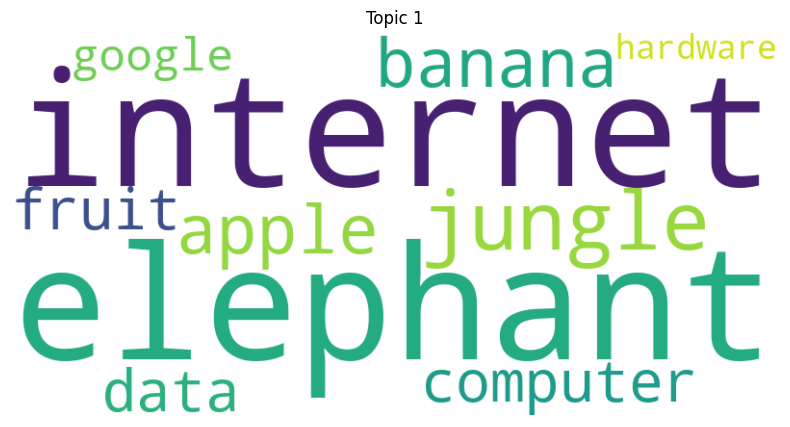

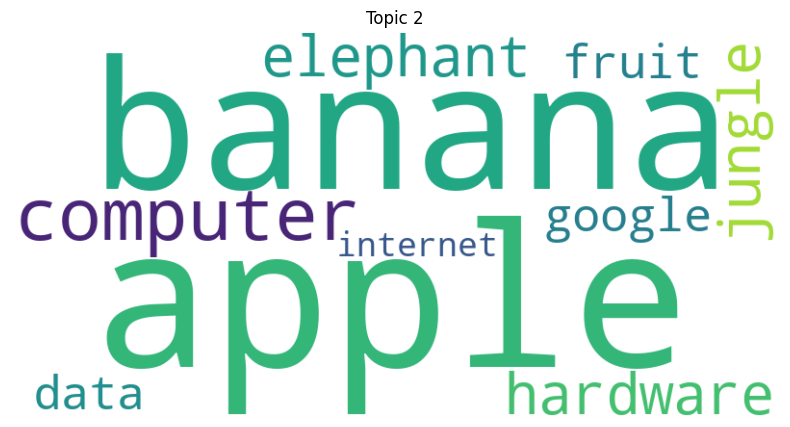

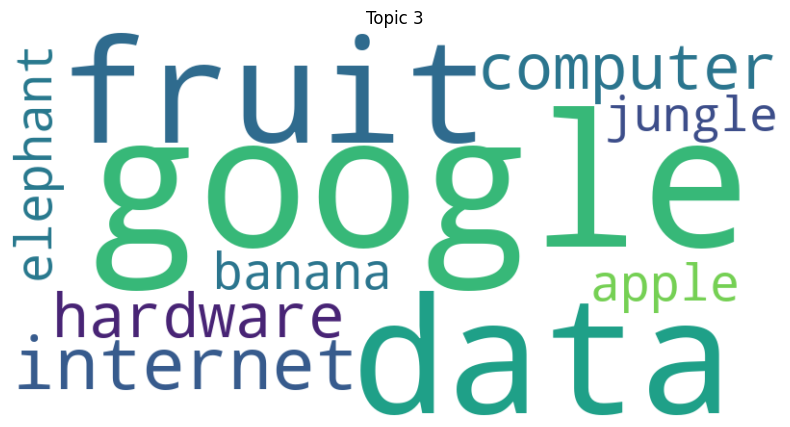

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def baby_lda(docs, vocab, K=6, max_iter=1000):
    """
    Implementation of a simple Latent Dirichlet Allocation algorithm
    
    Parameters:
    -----------
    docs : list of lists
        Each inner list contains word indices for a document
    vocab : list
        List of strings where index corresponds to word indices in docs
    K : int
        Number of topics
    max_iter : int
        Maximum number of Gibbs sampling iterations
        
    Returns:
    --------
    Z : numpy array
        Document-word topic assignments
    A : numpy array
        Document-topic counts
    B : numpy array
        Topic-word counts
    """
    # Data dimensions
    N = len(docs)                           # Number of documents
    W = len(vocab)                          # Vocabulary size
    DLMAX = max(len(d) for d in docs)       # Maximum document length
    
    # Create document-word matrix
    # DOCS[d,i] = w means the i-th word in doc d is w (index in vocab)
    DOCS = np.zeros((N, DLMAX), dtype=int)
    for d, doc in enumerate(docs):
        for i, word_idx in enumerate(doc):
            DOCS[d, i] = word_idx
    
    # Initialize hyperparameters
    alpha = np.ones(K) * 5                  # Dirichlet prior for document-topic distributions
    beta = np.ones(W) * 2                   # Dirichlet prior for topic-word distributions
    
    # Initialize count matrices
    Z = np.zeros((N, DLMAX), dtype=int)     # Topic assignments for each word
    A = np.tile(alpha, (N, 1))              # Document-topic counts with alpha prior
    B = np.tile(beta, (K, 1))               # Topic-word counts with beta prior
    
    # Sum of B for each topic (used for normalization)
    BSUM = np.sum(B, axis=1)
    
    # Gibbs sampling
    for t in range(max_iter):
        for d in range(N):
            doc_length = len(docs[d])  # Get actual document length
            for i in range(doc_length):
                w = DOCS[d, i]          # Get word index
                zi = Z[d, i]            # Current topic assignment
                
                # Subtract current topic assignment from counts
                if zi > 0:              # Skip if no topic assigned yet (zero is not a valid topic)
                    A[d, zi-1] -= 1      # Topics are 1-indexed in the algorithm, 0-indexed in Python
                    B[zi-1, w] -= 1      
                    BSUM[zi-1] -= 1
                
                # Compute probability distribution over topics
                p_z = A[d, :] * (B[:, w] / BSUM)
                
                # Normalize to get proper probability distribution
                p_z = p_z / np.sum(p_z)
                
                # Sample new topic
                new_zi = np.random.choice(K, p=p_z) + 1  # +1 because topics are 1-indexed in algorithm
                
                # Update assignments and counts
                Z[d, i] = new_zi
                A[d, new_zi-1] += 1
                B[new_zi-1, w] += 1
                BSUM[new_zi-1] += 1
                
        # Print progress
        if (t+1) % 100 == 0:
            print(f"Completed iteration {t+1}/{max_iter}")
    
    return Z, A, B

def display_topics(B, vocab, n_top_words=20):
    """
    Display the top words for each topic
    
    Parameters:
    -----------
    B : numpy array
        Topic-word counts
    vocab : list
        Vocabulary list
    n_top_words : int
        Number of top words to display for each topic
    """
    for k in range(B.shape[0]):
        # Get the indices of the top words for this topic
        top_word_indices = np.argsort(-B[k, :])[:n_top_words]
        
        # Get the actual words
        top_words = [vocab[i] for i in top_word_indices]
        
        # Get the weights (counts)
        weights = B[k, top_word_indices]
        
        print(f"Topic {k+1}:")
        for word, weight in zip(top_words, weights):
            print(f"  {word}: {weight:.2f}")
        print()

def create_wordclouds(B, vocab, save_path=None):
    """
    Create wordclouds for each topic
    
    Parameters:
    -----------
    B : numpy array
        Topic-word counts
    vocab : list
        Vocabulary list
    save_path : str
        Path to save wordcloud images (if None, displays instead)
    """
    K = B.shape[0]
    for k in range(K):
        # Create dictionary of word:weight pairs
        word_weights = {vocab[i]: float(B[k, i]) for i in range(len(vocab))}
        
        # Generate wordcloud
        wordcloud = WordCloud(width=800, height=400, 
                             background_color='white',
                             max_words=50).generate_from_frequencies(word_weights)
        
        # Display or save
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {k+1}")
        
        if save_path:
            plt.savefig(f"{save_path}/topic_{k+1}.png")
            plt.close()
        else:
            plt.show()

# Example usage
if __name__ == "__main__":
    # Sample data (would normally be preprocessed text)
    # This is just a simple example with toy data
    vocab = ["apple", "banana", "computer", "data", "elephant", "fruit", 
             "google", "hardware", "internet", "jungle"]
    
    # Create some simple documents with word indices
    docs = [
        [0, 1, 5],                # fruit-related
        [2, 3, 6, 8],             # tech-related
        [0, 1, 4, 5, 9],          # mixed fruit and animals
        [2, 6, 7, 8],             # tech-related
        [0, 4, 9],                # animals and fruit
        [2, 3, 6, 7, 8]           # tech-related
    ]
    
    # Run LDA
    K = 3  # Let's use 3 topics for this example
    Z, A, B = baby_lda(docs, vocab, K=K, max_iter=500)
    
    # Display results
    print("Document-Topic Distribution:")
    for d in range(len(docs)):
        print(f"Document {d+1}: {A[d] / np.sum(A[d])}")
    
    print("\nTopic-Word Distribution:")
    display_topics(B, vocab)
    
    # Create wordclouds
    create_wordclouds(B, vocab)